# AirplaneHubs Datastory
- Welche Flughäfen weisen einen hohen Flugverkehr auf?                            -> Verkehr an Flughäfen
- Welche Flughäfen weisen die meisten Verbindungen auf?                           -> Verkehr an Flughäfen
- Welche Flughäfen können als Verkehrsknotenpunkt identifiziert werden?           -> Verkehr an Flughäfen
- Welches sind die längsten Distanzen die zurückgelegt werden?                    -> Distanzen
- Welche Unterschiede in den Flugbewegungen sind im Sommer zum Frühling zu sehen? -> Unterschied Mai Sept

In [1]:
#load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descriptive_stats as ds
import plotly.express as px
import seaborn as sns

df_airports = pd.read_csv("data/preprocessed/airports.csv")
df_flights = pd.read_csv("data/preprocessed/flights.csv")

### Verkehr an Flughäfen
Als erstes möchten wir bestimmen, welche Flughäfen den höchsten Flugverkehr aufweisen. Dafür untersuchen wir das Datenset sortiert nach allen Takeoffs sowie Landings. 

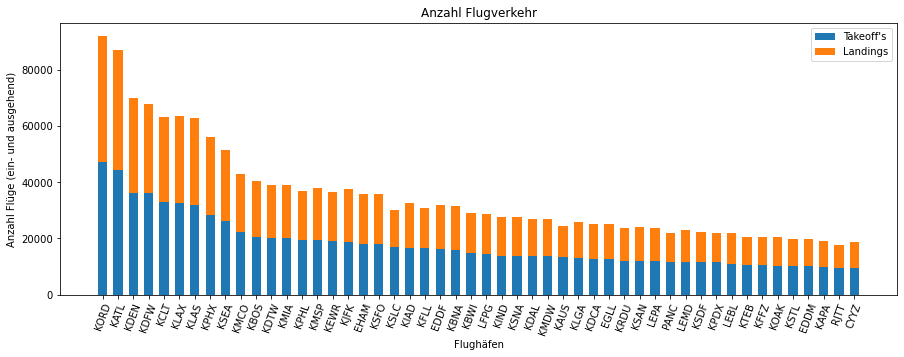

In [2]:
df_takeoffs = df_airports.sort_values(['takeoffs'], ascending=False).head(50)
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.bar(df_takeoffs['ident'], df_takeoffs['takeoffs'], width=0.6, label="Takeoff's")
_ = ax.bar(df_takeoffs['ident'], df_takeoffs['landings'], width=0.6, bottom=df_takeoffs['takeoffs'], label="Landings")
_ = ax.set_title("Anzahl Flugverkehr")
_ = ax.set_xlabel("Flughäfen")
_ = ax.set_ylabel("Anzahl Flüge (ein- und ausgehend)")
_ = ax.set_xticks(df_takeoffs['ident'])
_ = ax.set_xticklabels(df_takeoffs['ident'],rotation=70)
_ = ax.legend()

Die dargestellten Flughäfen befinden sich ausschlieslich in USA. Flughäfen aus Europa, Asien oder Afrika sind nicht mehr auf der Visualisierung zu erkennen. Um Knotenpunkte zu identifizieren, untersuchen wir die Bewegungen erneut separiert nach Regionen. Als erstes möchten wir jedoch die Anzahl Flugbewegungen pro Region aufzeigen.

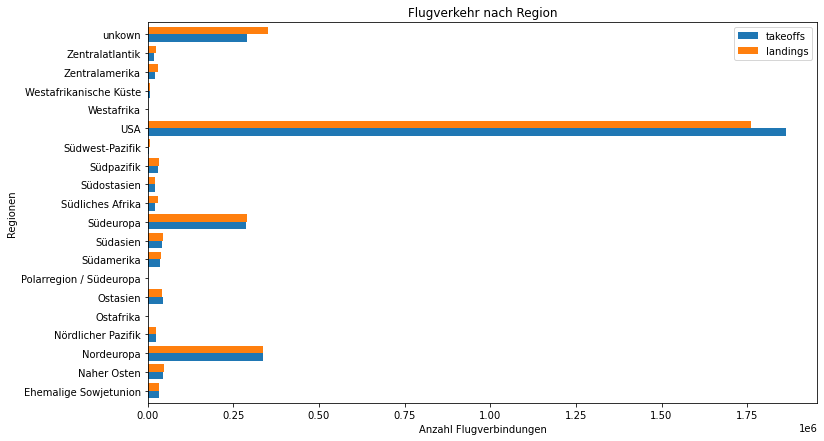

In [3]:
o = df_airports.groupby(['region'], as_index=False)[['takeoffs', 'landings', 'total']].sum()
g = o.plot(x='region', y=['takeoffs','landings'], kind='barh', width=.8, figsize=(12,7)).set(
    title='Flugverkehr nach Region', xlabel="Anzahl Flugverbindungen", ylabel="Regionen")

Der Unterschied zwischen der USA zu anderen Regionen ist sehr gross. Um Knotenpunkte auf der Welt zu identifizieren, müssen Flughäfen in ihrer Region unterschieden werden. Ansonsten sind ausschliesslich Flughäfen der USA wegen des hohen Flugverkehrs Knotenpunkte. Ein weiteres Indiz wären Transit-Flüge bzw. das Passagieraufkommen pro Flug, welche jedoch im Datenset nicht enthalten ist. Infolgedessen unterscheiden wir nun Flughäfen in Ihrer Region und selektieren daraus jeweils die 5 grössten Flughäfen.

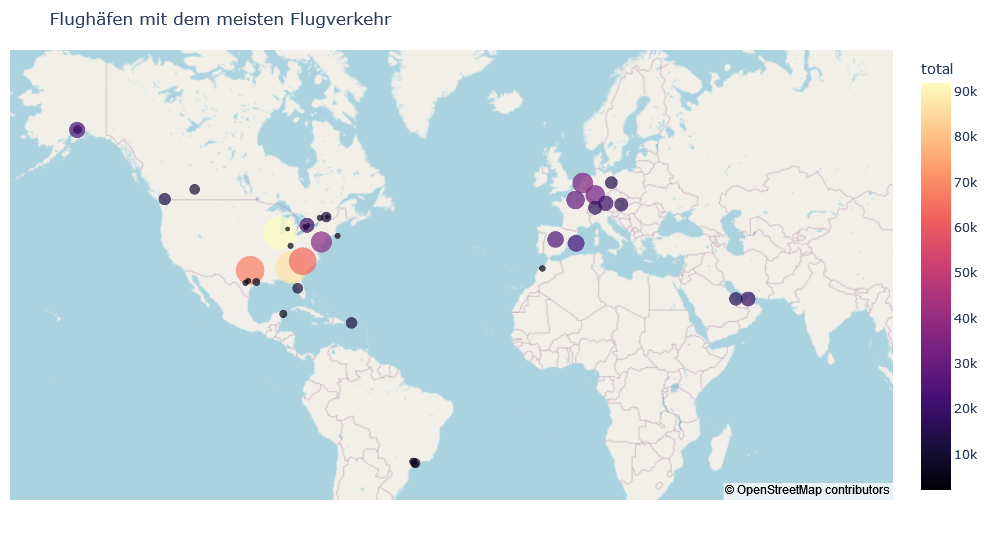

In [4]:
regions = df_airports[df_airports['total'] != 0].groupby(['region', 'ident'])[['total','takeoffs','landings','count_destinations']].sum().reset_index()
q = regions.groupby('region')[['total','count_destinations','takeoffs','landings']].quantile(0.993)
labels = {'total':'qt', 'count_destinations':'qc', 'takeoffs':'qd', 'landings':'ql'}
q = q.rename(columns=labels)
regions = df_airports.set_index('region')
df_new = regions.join(q).reset_index()

#5 biggest airports of each region
most_traffic = df_new.loc[(df_new['total'] > df_new['qt']) & (df_new['count_destinations'] > df_new['qc'])]
fig = px.scatter_mapbox(most_traffic, lat="latitude", lon="longitude",
                  color="total", size="total",
                  color_continuous_scale='magma',
                  size_max=24, zoom=1.2, hover_name='municipality', 
                  hover_data = ['name'], 
                  title = 'Flughäfen mit dem meisten Flugverkehr',
                  width=900, height=540)
fig.update_layout(mapbox_style="open-street-map", margin=dict(l=10, r=10, t=50, b=40))
fig.show()

Mit Abstand am meisten Flugverkehr weist der internationale Airport von Chicaco auf, welcher nach kurzer Wikipedia-Recherche weltweit auch am meisten Flugverkehr im 2021 darstellt. In Europa sind bis auf Mallorca die wohl bekanntesten, grössten Flughäfen vertreten mit: London, Paris, Frankfurt und Amsterdam. Das Mallorca als Knotenpunkt identifiziert wurde, liegt höchstwarscheinlich  wegen der Ferienzeit, den Mallorca ist nicht bekannt als Hub-Flughafen sondern eher als Ferienort.
<br><br>
Ansonsten spiegelt die Visualisierung unsere Erwartungen wieder, welche die grössten und wichtigsten Flughäfen darstellen wie Doha, Dubai, Sydney, Tokio, Hong-Kong, Neu Delhi etc.. <br><br>
Enttäuschend sind die fehlenden Knotenpunkte in Südamerika, da uns bekannt ist, dass Sao Paulo ein grosses Flugaufkommen besitzt. Infolgedessen möchten wir erneut versuchen, Knotenpunkte weiter zu untersuchen anhand der unterschiedlichen Destinationen pro Flughafen. Die Anzahl unterschiedlicher Ziele des Flughafens kann Aufschluss auf die Vielfalt der Verbindungen des Flughafens geben und so besser aufzeigen, welches Knotenpunkte sind. 

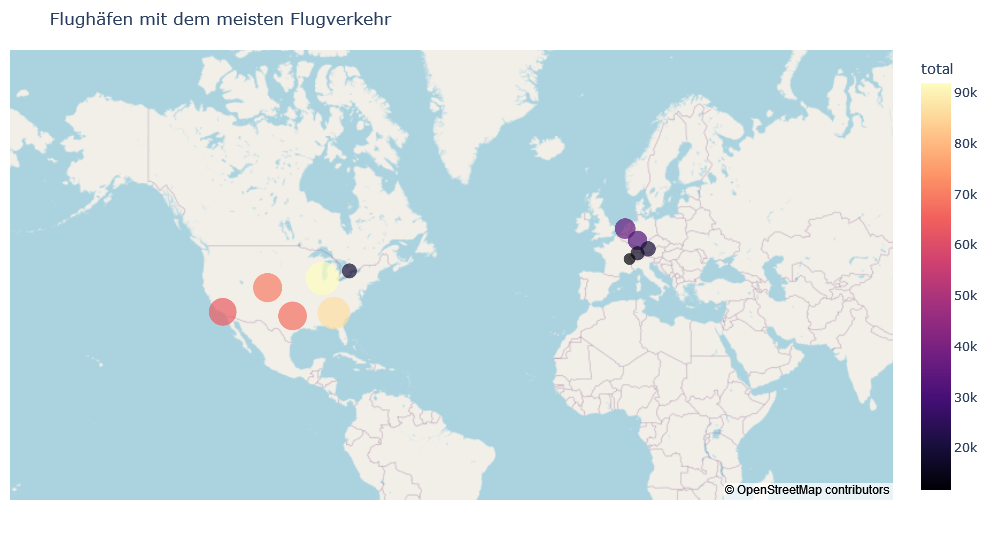

In [5]:
q = df_airports.quantile(q=.99)

df = df_airports[df_airports['count_destinations'] > q['count_destinations']]

other  = df.loc[(df['region'] != 'unkown') & (df['region'] != 'USA') & (df['region'] != 'Südeuropa') & (df['region'] != 'Nordeuropa')].sort_values('total', ascending=False).head(10)
usa    = df.loc[df['region'] == 'USA'].sort_values('total', ascending=False).head(5)
europa = df.loc[(df['region'] == 'Südeuropa') | (df_airports['region'] == 'Nordeuropa')].sort_values('total', ascending=False).head(5)
unkown = df.loc[df['region'] == 'unkown'].sort_values('total', ascending=False).head(5)

#5 biggest airports of each region
most_traffic = pd.concat([usa, europa, unkown, other])

fig = px.scatter_mapbox(most_traffic, lat="latitude", lon="longitude",
                  color="total", size="total",
                  color_continuous_scale='magma',
                  size_max=24, zoom=1.2, hover_name='municipality', 
                  hover_data = ['name'], 
                  title = 'Flughäfen mit dem meisten Flugverkehr',
                  width=900, height=540)
fig.update_layout(mapbox_style="open-street-map", margin=dict(l=10, r=10, t=50, b=40))
fig.show()

Fazit: Wie wir erkennen können, ist keine grösse Änderung zur vorherigen Visualisierung zu erkennen. 
Trotzdem gab es kleine, wichtige Änderungen. Nun ist Sao Paolo auf der Karte ersichtlich, welcher als einer der grössten Flughäfen von Südamerika gilt - somit wurden unsere Erwartungen erfüllt, eine bessere Vielfalt bereitzustellen. 
Ausserdem ist beispielsweise in Australien nur noch Sydney als Knotenpunkt ersichtlich anstatt mit Melbourne. Um noch weitere und bessere Analysen zu generieren, wären Daten zum Land sowie des Passagieraufkommens notwendig wobei unterschieden werden kann in Transit-Flüge und normale Flüge. 

### Längste Distanzen
Im folgenden Abschnitt möchten wir aufzeigen, welche Flugverbindungen die längsten Distanzen aufweisen. Dabei möchten wir beispielsweise aufzeigen, ob grosse Distanz gleich grosser Flughafen bedeutet. Weisen auch kleine Flughäfen grosse Distanzen auf? Wenn ja welche sind dies und warum?

index callsign origin destination         day      distance  counts  \
0    481483   ETH672   SBGR        RJAA  2021-05-12  18490.121459       1   
1   1357455  ETH3739   VHHH        SBGR  2021-05-29  18017.353233       8   
2    352199   ETD68W   YMML        LEMD  2021-05-09  17286.348883       1   
3    994320   QFA109   YSSY        EGLL  2021-05-22  17016.029309       5   
4     81085    UNDEF   KOAK        FAOR  2021-05-03  16966.825448       1   
5   2310962  FDX6003   YSSY        LFPG  2021-09-17  16941.242499       2   
6   2076826   QFA109   YMML        EGLL  2021-09-13  16903.780987       1   
7    646709   ETD99E   YSSY        LSGG  2021-05-15  16776.711316       1   
8   1786901  QFA7554   KJFK        YMML  2021-09-08  16695.376130       2   
9   2011000    UNDEF   YMML        KTEB  2021-09-11  16674.466366       1   
10  1451286    UNDEF   YMEN        KTEB  2021-05-30  16671.430246       1   
11  1893159    UNDEF   YSSY        EHAM  2021-09-10  16653.428814       1   
12    18976    UNDEF   FAGM        WA46  2021-05-01  16635.935980       1   
13       25   ETD39B   YSSY        LSZH  2021-05-01  16565.313752       2   
14   893134  FDX5030   YSSY        EDDK  2021-05-20  16560.284145       4   
15  1843294   CCA577   YSSY        EDDF  2021-09-09  16492.326650       1   
16    17010   ETD33V   YSSY        EDDM  2021-05-02  16308.426578       1   
17   242578   ETD141   YMML        CYYZ  2021-05-07  16248.915378       3   
18    30595   ETD11B   WIII        KJFK  2021-05-02  16180.472009       1   
19  2076911   QFA115   YBBN        EDDF  2021-09-13  16097.875704       1   

        o_lat      o_long      d_lat      d_long  
0  -23.435556  -46.473057  35.764702  140.386002  
1   22.308901  113.915001 -23.435556  -46.473057  
2  -37.673302  144.843002  40.471926   -3.562640  
3  -33.946098  151.177002  51.470600   -0.461941  
4   37.721298 -122.221001 -26.139200   28.246000  
5  -33.946098  151.177002  49.012798    2.550000  
6  -37.673302  144.843002  51.470600   -0.461941  
7  -33.946098  151.177002  46.238098    6.108950  
8   40.639801  -73.778900 -37.673302  144.843002  
9  -37.673302  144.843002  40.850101  -74.060799  
10 -37.728100  144.901993  40.850101  -74.060799  
11 -33.946098  151.177002  52.308601    4.763890  
12 -26.242500   28.151199  45.830299 -122.637001  
13 -33.946098  151.177002  47.464699    8.549170  
14 -33.946098  151.177002  50.865898    7.142740  
15 -33.946098  151.177002  50.033333    8.570556  
16 -33.946098  151.177002  48.353802   11.786100  
17 -37.673302  144.843002  43.677200  -79.630600  
18  -6.125570  106.655998  40.639801  -73.778900  
19 -27.384199  153.117004  50.033333    8.570556

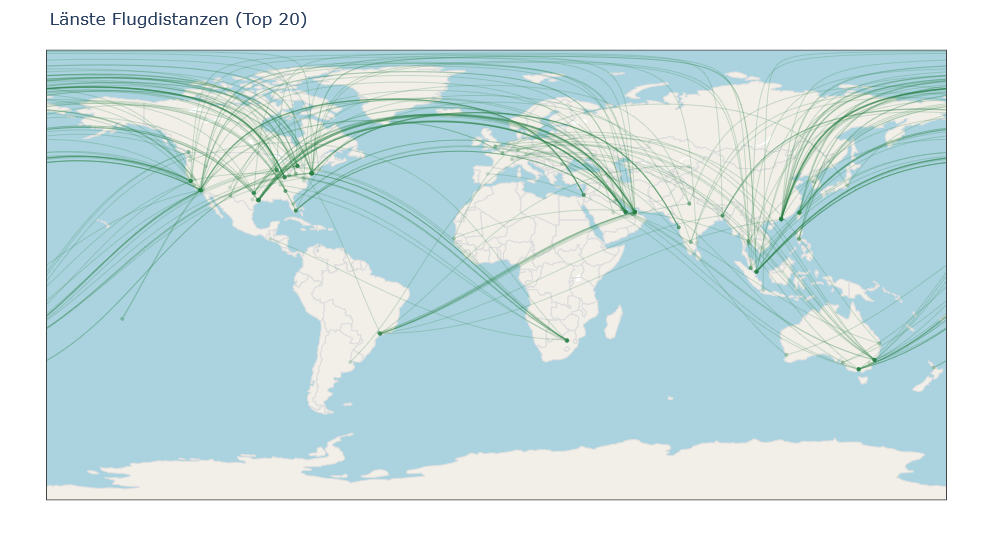

In [6]:
import plotly.graph_objects as go

##TODO: drop unnamed column

#create dictionary of airports
airportsDict = df_airports.set_index("ident").to_dict("index")

#only flights with distances > 1.0
flightDistances = df_flights[df_flights.distance > 1.0]
#sort flights by distance descending
flightDistances = flightDistances.sort_values(by=["distance"], ascending=False)
#assign airports group-count to flightDistances.counts
flightDistances["counts"] = flightDistances.groupby("distance")["distance"].transform("count")
#drop duplicates from flightDistances
flightDistances.drop_duplicates(subset=["distance"], inplace=True)

#add columns o_lat, o_long, d_lat, d_long
flightDistances["o_lat"] = flightDistances.origin.apply(lambda a: airportsDict[a]["latitude"])
flightDistances["o_long"] = flightDistances.origin.apply(lambda a: airportsDict[a]["longitude"])
flightDistances["d_lat"] = flightDistances.destination.apply(lambda a: airportsDict[a]["latitude"])
flightDistances["d_long"] = flightDistances.destination.apply(lambda a: airportsDict[a]["longitude"])

#first 200 flight distances
topFlightDistances = flightDistances.reset_index().head(200)

#display top 20 flight distances
display(topFlightDistances.head(20))


#create figure
fig = go.Figure()

#add flight traces to map
flight_paths = []
for index, row in topFlightDistances.iterrows():
    fig.add_trace(
        go.Scattergeo(
            locationmode = "country names",
            lon = [row["o_long"], row["d_long"]],
            lat = [row["o_lat"], row["d_lat"]],
            mode = "lines+markers",
            line = dict(width = 1, color = "#267F42"),
            opacity = 0.22,
            name = "",
            text = str(row["origin"])+" to "+str(row["destination"])+", "+str(round(row["distance"], 2))+"km, "+str(row["counts"])+" times",
            marker = {"size": 4}
        )
    )

#visualization adjustments
fig.update_traces(
    hoverinfo = "text",
)    

fig.update_layout(
    title_text = "Länste Flugdistanzen (Top 20)",
    showlegend = False,
    width=900, height=540,
    margin=dict(l=10, r=10, t=50, b=40),
    geo = dict(
        scope = "world",
        #projection_type = "orthographic",
        showland = True,
        showocean = True,
        showcoastlines = False,
        showcountries = True,
        landcolor = "#F2EFE9",
        countrycolor = "#DDDDDD",
        oceancolor = "#AAD3DF",
        bgcolor = "#FFFFFF",
    ),
)


### Flugdistanzen kleiner Flughäfen

In [7]:
#small airports
small_airports = df_airports[(df_airports.total > 0) & (df_airports.type == "small_airport")]
#idents list
small_airports_idents = small_airports["ident"].unique().tolist()
#all flights started from a small airports
flights_from_small_airports = df_flights[(df_flights.origin.isin(small_airports_idents)) ]
#sort by distance
flights_from_small_airports = flights_from_small_airports.sort_values(by="distance", ascending=False)
#assign airports group-count to flightDistances.counts
flights_from_small_airports["counts"] = flights_from_small_airports.groupby("distance")["distance"].transform("count")
#drop duplicates
flights_from_small_airports.drop_duplicates(subset=["distance"], inplace=True)

#add columns o_lat, o_long, d_lat, d_long
flights_from_small_airports["o_lat"] = flights_from_small_airports.origin.apply(lambda a: airportsDict[a]["latitude"])
flights_from_small_airports["o_long"] = flights_from_small_airports.origin.apply(lambda a: airportsDict[a]["longitude"])
flights_from_small_airports["d_lat"] = flights_from_small_airports.destination.apply(lambda a: airportsDict[a]["latitude"])
flights_from_small_airports["d_long"] = flights_from_small_airports.destination.apply(lambda a: airportsDict[a]["longitude"])

#top 20 flight distances from small airports
top_flights_from_small_airports = small_airports_flightDistances.reset_index().head(20)
#list of top 20 small airport origins
top_flights_from_small_airports_list = top_flights_from_small_airports.origin.tolist()

print("Längste Flüge kleiner Flughäfen: ")
display(top_flights_from_small_airports[["origin", "destination", "day", "distance", "counts"]].head())

print("Kleine Flughäfen mit längsten Distanzen: ")
display(small_airports[["name", "municipality", "region", "total"]][small_airports.ident.isin(top_flights_from_small_airports_list)].head())


#create figure
fig2 = go.Figure()

#add flight traces to map
for index, row in small_airports_flightDistances_top.iterrows():
    fig2.add_trace(
        go.Scattergeo(
            locationmode = "country names",
            lon = [row["o_long"], row["d_long"]],
            lat = [row["o_lat"], row["d_lat"]],
            mode = "lines+markers",
            line = dict(width = 1, color = "#E6A64C"),
            opacity = 0.69,
            name = "",
            text = str(row["origin"])+" to "+str(row["destination"])+", "+str(round(row["distance"], 2))+"km, "+str(row["counts"])+" times",
            marker = {"size": 8}
        )
    )

#visualization adjustments
fig2.update_traces(
    hoverinfo = "text",
)    

fig2.update_layout(
    title_text = "Länste Flugdistanzen kleiner Flughäfen (Top 20)",
    showlegend = False,
    width=900, height=540,
    margin=dict(l=10, r=10, t=50, b=40),
    geo = dict(
        scope = "world",
        #projection_type = "orthographic",
        showland = True,
        showocean = True,
        showcoastlines = False,
        showcountries = True,
        landcolor = "#F2F2F2",
        countrycolor = "#DDDDDD",
        oceancolor = "#FFFFFF",
        bgcolor = "#FFFFFF",
    ),
)



NameError: name 'small_airports_flightDistances' is not defined

### Unterschied Mai und September
Wie bereits bei Beginn kurz angedeutet, ist der Flugverkehr im September um rund 10'000 Verbindungen höher als im Mai. 



callsign origin destination         day     distance month  month_count
0   CCA583   KLAX        EDDF  2021-05-01  9344.153346   May      1493562
1  VCV3770   LYBE        UUWW  2021-05-01  1694.492080   May      1493562
2  UTN4490   UKBB        UKBB  2021-05-01     0.000000   May      1493562
3   CCA627   ZGSZ        EDDF  2021-05-01  9133.793170   May      1493562
4   CES553   RJBB        LFPG  2021-05-01  9648.489241   May      1493562

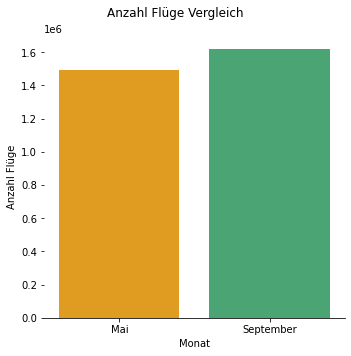

In [8]:
#diffs between may and sept
df_diff = df_flights
df_diff["month"] = df_diff["day"].apply(lambda day: "May" if "-05-" in day else "September")
df_diff["month_count"] =  df_diff.groupby("month")["month"].transform("count")
display(df_diff.head())


# flights mai vs sept
h = sns.catplot(
    data=df_diff, kind="bar",
    x="month", y="month_count",
    palette=sns.color_palette(['orange', 'mediumseagreen'])
)
_ = h.despine(left=True) #remove left spine
_ = h.set_axis_labels("Monat", "Anzahl Flüge")
_ = h.fig.subplots_adjust(top=0.9) 
_ = h.set(xticklabels=["Mai", "September"])
_ = h.fig.suptitle("Anzahl Flüge Vergleich")

### Beliebteste Routen

In [9]:
# most popular routes [not working properly]
def popularRoutes(df):
    result = df
    result["route"] = df["origin"]+df["destination"]
    result["count"] =  result.groupby("route")["route"].transform("count")
    result.drop_duplicates(subset=["route"], inplace=True)
    result = result.sort_values(["count"], ascending=False).head(20)
    return result


popRoutes = popularRoutes(df_flights)
display(popRoutes.head(20))
    

callsign origin destination         day  distance month  month_count  \
1125   OXF4263   KFFZ        KFFZ  2021-05-01       0.0   May      1493562   
3479     UNDEF   KBJC        KBJC  2021-05-01       0.0   May      1493562   
1763     UNDEF   KMYF        KMYF  2021-05-01       0.0   May      1493562   
1364     UNDEF   KAPA        KAPA  2021-05-01       0.0   May      1493562   
2770     UNDEF   KIWA        KIWA  2021-05-01       0.0   May      1493562   
478      UNDEF   KDVT        KDVT  2021-05-01       0.0   May      1493562   
1799     UNDEF   KLAF        KLAF  2021-05-01       0.0   May      1493562   
3509     UNDEF   KHWO        KHWO  2021-05-01       0.0   May      1493562   
16891    FDL51   KFRG        KFRG  2021-05-01       0.0   May      1493562   
2669     UNDEF   KCHD        KCHD  2021-05-01       0.0   May      1493562   
2272     UNDEF   KBFI        KBFI  2021-05-01       0.0   May      1493562   
1555     UNDEF   KHIO        KHIO  2021-05-01       0.0   May      1493562   
2267     UNDEF   KLGB        KLGB  2021-05-01       0.0   May      1493562   
2917     UNDEF   KSDL        KSDL  2021-05-01       0.0   May      1493562   
22406    TRF90   KADS        KADS  2021-05-01       0.0   May      1493562   
2026     UNDEF   KSEE        KSEE  2021-05-01       0.0   May      1493562   
1842     UNDEF   KVNY        KVNY  2021-05-01       0.0   May      1493562   
2963     UNDEF   KTOA        KTOA  2021-05-01       0.0   May      1493562   
1798     UNDEF   KCRQ        KCRQ  2021-05-01       0.0   May      1493562   
1770     UNDEF   KVGT        KVGT  2021-05-01       0.0   May      1493562   

          route  count  
1125   KFFZKFFZ   7291  
3479   KBJCKBJC   4446  
1763   KMYFKMYF   4398  
1364   KAPAKAPA   4311  
2770   KIWAKIWA   4049  
478    KDVTKDVT   3946  
1799   KLAFKLAF   3476  
3509   KHWOKHWO   3141  
16891  KFRGKFRG   3058  
2669   KCHDKCHD   3044  
2272   KBFIKBFI   2899  
1555   KHIOKHIO   2853  
2267   KLGBKLGB   2799  
2917   KSDLKSDL   2795  
22406  KADSKADS   2738  
2026   KSEEKSEE   2686  
1842   KVNYKVNY   2571  
2963   KTOAKTOA   2529  
1798   KCRQKCRQ   2512  
1770   KVGTKVGT   2495